In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import ot
from ipywidgets import interact

from psgla import *
from myula import *
from pdla import *
import distributions as pds
import potentials as pot

In [2]:
%matplotlib inline

**Define the posterior distribution**\
The prior is assumed to be a Gamma distribution with shape parameter $\alpha = \frac{\nu}{2}$, the likelihood is mean estimation for the data points $d_i$:\
$$\pi(x) \propto \exp(-V(x)),\quad V(x) = \frac{1}{2\sigma^2}\sum_{i=1}^n (x - d_i)^2 + (1-\nu/2)\log x + x/2 =: F(x) + G(x),$$
or written differently for PDLA: $$V(x) = \frac{1}{2\sigma^2}\lVert\mathbf{1}x - d\rVert_2^2 + (1-\nu/2)\log x + x/2 =: D(Kx) + G(x)$$ where $K = \mathbf{1}$.
Require $\nu > 2$ since we want a log-concave distribution.

**PSGLA:**
$$ X_{k+1} = \textrm{prox}_{\tau G} \left(X_k - \tau \nabla F(X_k) + \sqrt{2\tau}\, \xi_{k+1} \right) $$
**MYULA:**
$$ X_{k+1} = X_k - \tau \nabla F(X_k) - \tau \nabla(G^\gamma)(X_k) + \sqrt{2\tau}\, \xi_{k+1} $$
**PDLA:**
$$ \begin{array}{l}
Y_{k+1} = \textrm{prox}_{\sigma D^\ast} \left(Y_k + \sigma K (2X_k-X_{k-1}) \right)\\
X_{k+1} = \textrm{prox}_{\tau G} \left(X_k - \tau K^\ast Y_{k+1} + \sqrt{2\tau}\, \xi_{k+1} \right)\\
\end{array}$$

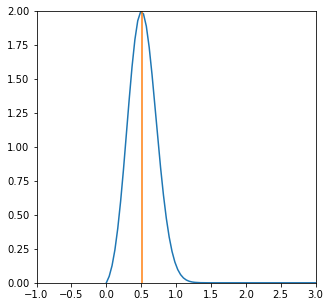

In [3]:
mu_true = 0.8
sigma2_true = 0.5
n_data = 10
nu = 4
rng = default_rng(34523)
data = rng.normal(loc=mu_true,scale=np.sqrt(sigma2_true),size=(n_data,))
posterior = pds.Gamma_Gauss1D_Posterior_Salim21(data=data, scale=np.sqrt(sigma2_true), nu=nu)
# metaparameter of the distribution: norm of K in ||.||_2
L = np.linalg.norm(posterior.F.K)**2
t = np.reshape(np.linspace(1e-4, 5*nu+np.mean(data),500),(1,-1))
dens_vals = posterior.pdf(t)

plt.figure(figsize=(5,5))
unscaled_dens_plot = plt.plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)))
xlims = plt.xlim(-1, 3.0)
ylims = plt.ylim(0,2)
mu_map = sigma2_true/(2*n_data)*(n_data/sigma2_true*np.mean(data)-1/2 + np.sqrt((1/2-n_data/sigma2_true*np.mean(data))**2 - 4*n_data/sigma2_true*(1-nu/2)))
plt.plot([mu_map, mu_map],[0,2])
plt.show()

**Run PSGLA with tiny step to approximate the ground truth**

In [4]:
tau_almostgt_psgla = 0.9/L * 0.001
max_iter_almostgt = 2000
n_samples_gt = 1000
# initialize at the MAP
x0_gt = mu_map*np.ones((1,n_samples_gt))
psgla_almostgt = PSGLA(max_iter_almostgt, tau_almostgt_psgla, x0_gt, pd = posterior)

x_almostgt = psgla_almostgt.simulate(return_all=True)

**Sample using P(S)GLA, MYULA and PDLA**

In [14]:
max_iter = 40
n_samples = 1000

# PSGLA
tau_psgla = 0.9/L * 0.001
x0 = mu_map*np.ones((1,n_samples))
psgla = PSGLA(max_iter, tau_psgla, x0, pd = posterior)
x_psgla, W2dist_psgla = psgla.simulate(x_comp = x_almostgt[:,:,1000:2000],return_all=True)

# MYULA
gamma_myula = 0.5
tau_myula = 0.9/(L + 1/gamma_myula) * 0.001
myula = MYULA(max_iter, tau_myula, gamma_myula, x0, pd = posterior)
x_myula, W2dist_myula = myula.simulate(x_comp = x_almostgt[:,:,1000:2000],return_all=True)

# PDLA
tau_pdla = 0.9 * 0.001
sigma_pdla = tau_pdla/(0.9*L)
x0 = mu_map*np.ones((1,n_samples))
y0 = np.zeros((n_data,n_samples))
G_pdla = posterior.G
D_pdla = pot.L2norm(d=n_data,mu=np.reshape(data,(-1,1)))
K_pdla = np.ones((n_data,1))
pdla = PDLA(max_iter, sigma_pdla, tau_pdla, x0, y0, F=pot.Zero(), G=G_pdla, D=D_pdla, K=K_pdla)
x_pdla, y_pdla, W2dist_pdla = pdla.simulate(x_comp = x_almostgt[:,:,1000:2000],return_all=True)

**Compare PSGLA, MYULA and PDLA samples**

In [15]:
# density functions
my_posterior = pds.MY_Gamma_Gauss1D_Posterior_Salim21(data=data, scale=np.sqrt(sigma2_true), nu=4, gamma=gamma_myula)
t1 = np.reshape(np.linspace(1e-10, 4, 500),(1,-1))
t2 = np.reshape(np.linspace(-0.4, 4, 500),(1,-1))
dens_vals = posterior.pdf(t1)
my_dens_vals = my_posterior.pdf(t2)   
        
# histograms of samples
x_almostgt_r = np.reshape(x_almostgt[:,:,1000:2000], (-1,))
x_psgla = np.reshape(x_psgla, (n_samples,1,max_iter+1))
x_myula = np.reshape(x_myula, (n_samples,1,max_iter+1))
x_pdla = np.reshape(x_pdla, (n_samples,1,max_iter+1))

def hist_iterates(k=max_iter):
    fig, ax = plt.subplots(2, 2, figsize=(25,10))
    ax[0,0].set_xlim(-0.4, 3);  ax[0,0].set_ylim(0,2.2);
    
    pdf_plot_gt = ax[0,0].plot(np.reshape(t1,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[0,0].set_title('PSGLA, step = {:.1e}'.format(tau_almostgt_psgla));
    pdf_plot_psgla = ax[0,1].plot(np.reshape(t1,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[0,1].set_title('PSGLA, step = {:.1e}'.format(tau_psgla));
    pdf_plot_myula = ax[1,0].plot(np.reshape(t1,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    my_pdf_plot_myula = ax[1,0].plot(np.reshape(t2,(-1,)),np.reshape(my_dens_vals,(-1,1)), color='k',label='MY smoothed pdf')
    ax[1,0].set_title('MYULA, step = {:.1e}'.format(tau_myula));
    pdf_plot_pdla = ax[1,1].plot(np.reshape(t1,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[1,1].set_title('PDLA, tau = {:.1e}, sigma = {:.1e}'.format(tau_pdla,sigma_pdla));

    hist_gt = ax[0,0].hist(x_almostgt_r, 100, density=True);
    hist_psgla = ax[0,1].hist(x_psgla[:,:,k], 100, density=True);
    ax[0,1].set_xlim(-0.4, 3);  ax[0,1].set_ylim(0,2.2);
    hist_myula = ax[1,0].hist(x_myula[:,:,k], 100, density=True);
    ax[1,0].set_xlim(-0.4, 3);  ax[1,0].set_ylim(0,2.2);
    hist_pdla = ax[1,1].hist(x_pdla[:,:,k], 100, density=True);
    ax[1,1].set_xlim(-0.4, 3);  ax[1,1].set_ylim(0,2.2);
interact(hist_iterates, k=(0,max_iter))
#hist_iterates()

interactive(children=(IntSlider(value=40, description='k', max=40), Output()), _dom_classes=('widget-interact'…

<function __main__.hist_iterates(k=40)>

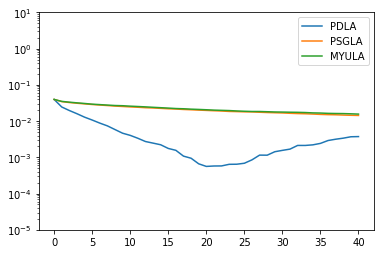

In [16]:
plt.semilogy(W2dist_pdla,label='PDLA')
plt.semilogy(W2dist_psgla, label='PSGLA')
plt.semilogy(W2dist_myula, label='MYULA')
plt.legend()
plt.ylim(1e-5,1e1);